# Demo

In [57]:
import utils
import random
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

### List all files in the dataset

In [58]:
# Specify the paths to the folders
data_dir = '../data/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'
normal_folder_path = os.path.join(data_dir, 'normal')
covid_folder_path = os.path.join(data_dir, 'covid')
pneumonia_folder_path = os.path.join(data_dir, 'pneumonia')

# Create DataFrames for each folder
normal_df = utils.create_dataframe(normal_folder_path, label=0)
covid_df = utils.create_dataframe(covid_folder_path, label=1)
pneumonia_df = utils.create_dataframe(pneumonia_folder_path, label=2)

# Concatenate the DataFrames into a single DataFrame
reference_df = pd.concat([normal_df, covid_df, pneumonia_df], ignore_index=True)

# Display the DataFrame
print(reference_df.head())

                      File  Label
0  normal\00000002_000.png      0
1  normal\00000005_000.png      0
2  normal\00000005_003.png      0
3  normal\00000005_004.png      0
4  normal\00000005_005.png      0


### Split the data into train, validation and test sets

In [59]:
# Split the data into train and test sets (80% train, 10% validation, 10% test)
train_reference_df, temp_df = train_test_split(reference_df, test_size=0.2, stratify=reference_df['Label'], random_state=123)
val_reference_df, test_reference_df = train_test_split(temp_df, test_size=0.3, stratify=temp_df['Label'], random_state=123)

utils.print_split(train_reference_df, val_reference_df, test_reference_df)

TRAIN SET
	Normal X-ray: 1220 (33.33%)
	COVID-19 X-ray: 1220 (33.33%)
	Pneumonia X-ray: 1220 (33.33%)
VALIDATION SET
	Normal ECG: 214 (33.44%)
	COVID-19 X-ray: 213 (33.28%)
	Pneumonia X-ray: 213 (33.28%)
TEST SET
	Normal ECG: 91 (33.09%)
	COVID-19 X-ray: 92 (33.45%)
	Pneumonia X-ray: 92 (33.45%)


### Image preprocessing

Class label:  2


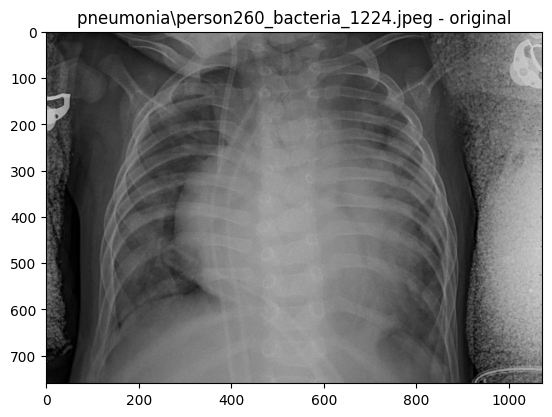

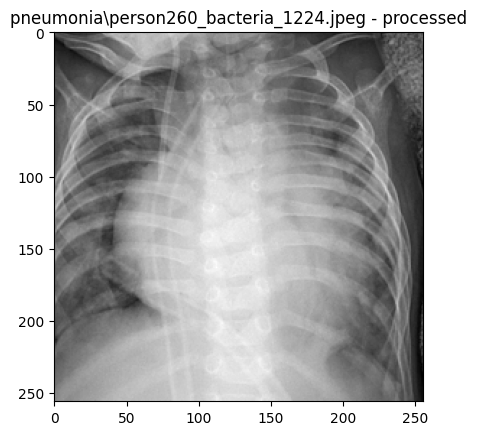

In [60]:
# Load a random image from the test set
#idx = random.randint(0, len(test_reference_df) - 1)
#print(idx)
idx = 167
file_name = test_reference_df.iloc[idx]['File']
actual_label = test_reference_df.iloc[idx]['Label']
original_image = utils.load_image(file_name, data_dir)
processed_image = utils.load_and_preprocess_data(file_name, data_dir)

plt.figure()
plt.imshow(original_image, cmap='gray')
plt.title('{} - original'.format(file_name))

target_size = (224, 224)

plt.figure()
plt.imshow(processed_image, cmap='gray')
plt.title('{} - processed'.format(file_name))

print("Class label: ", actual_label)

### Split the image into subpatches

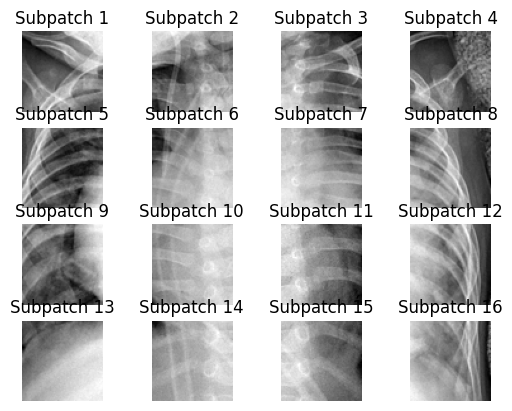

In [61]:
data = utils.load_and_preprocess_data(file_name, data_dir)
subpatches = utils.generate_subpatches(data, patch_size=(64, 64), overlap=(0, 0))
NO_SUBPATCHES = subpatches.shape[0]
utils.plot_subpatches(subpatches)

### Load the encoders

In [62]:
IMG_SHAPE = (64, 64, 1)
CODE_SIZE = 32
encoders=[]
decoders=[]
autoencoders=[]

for i in range (NO_SUBPATCHES):
    # restore trained weights
    encoder, decoder = utils.build_deep_autoencoder_2(IMG_SHAPE, code_size=CODE_SIZE)
    encoder.load_weights("../autoencoders/encoder"+ str(i) +".h5")
    decoder.load_weights("../autoencoders/decoder"+ str(i) +".h5")

    encoders.append(encoder)
    decoders.append(decoder)

### Inspect the autoencoder

1/1 [==============================] - 0s 87ms/step


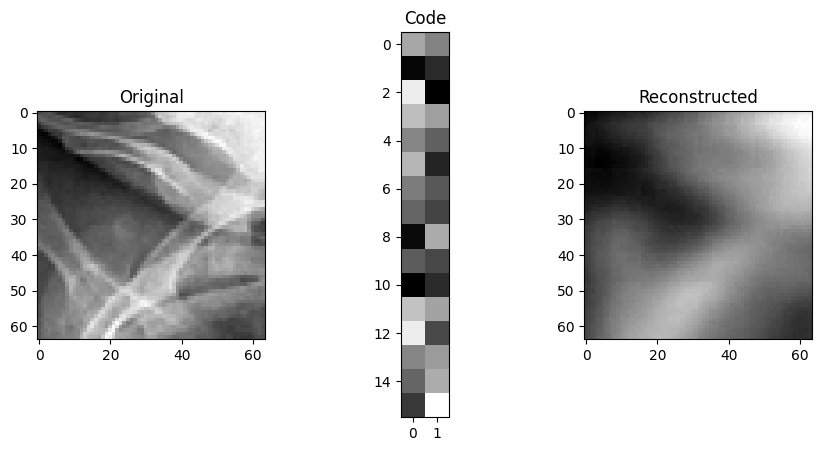

1/1 [==============================] - 0s 91ms/step


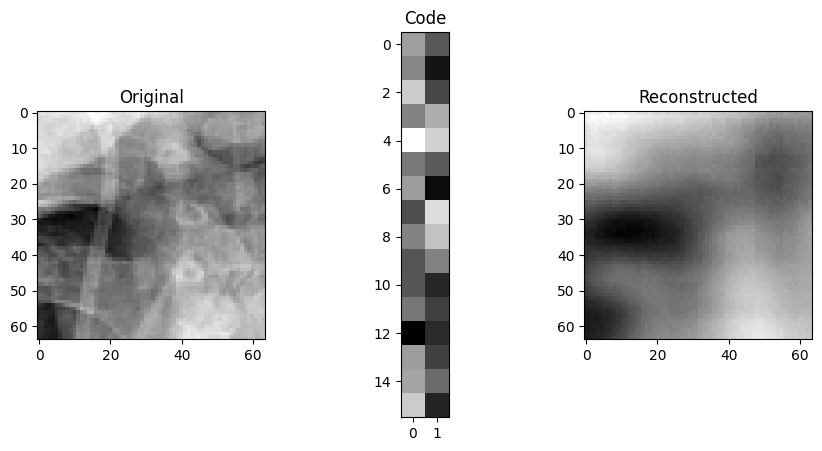

1/1 [==============================] - 0s 84ms/step


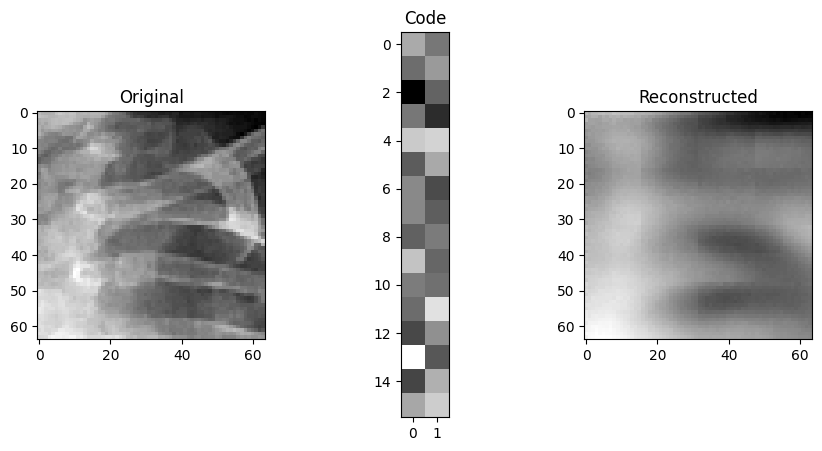

1/1 [==============================] - 0s 85ms/step


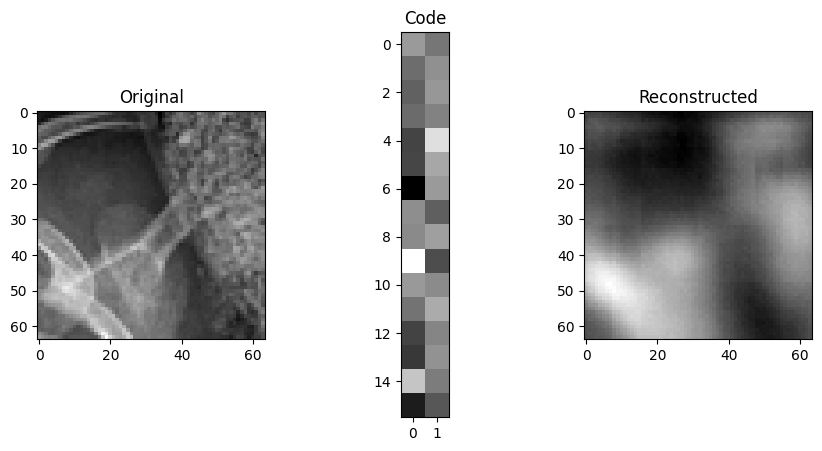

1/1 [==============================] - 0s 80ms/step


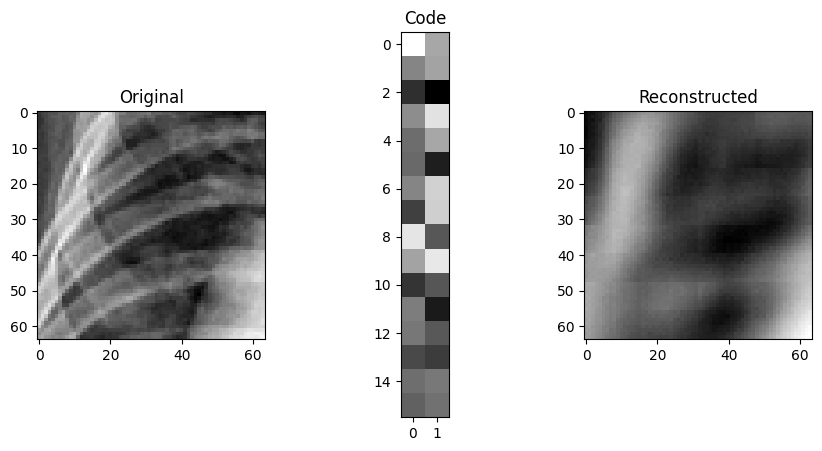

1/1 [==============================] - 0s 79ms/step


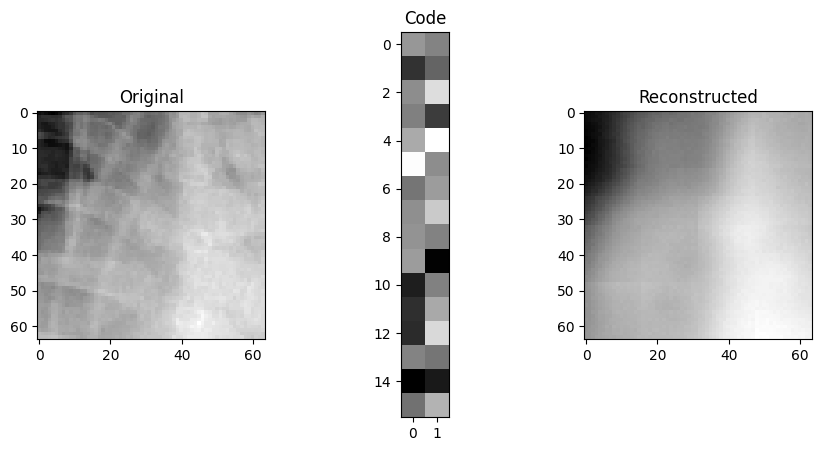

1/1 [==============================] - 0s 81ms/step


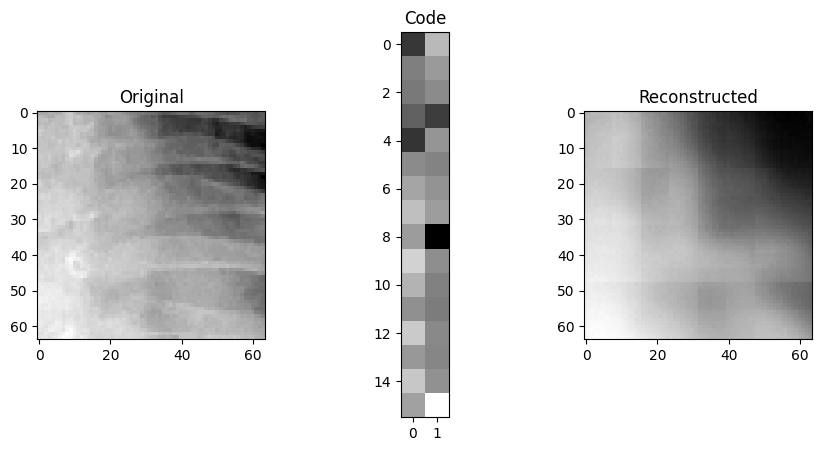

1/1 [==============================] - 0s 92ms/step


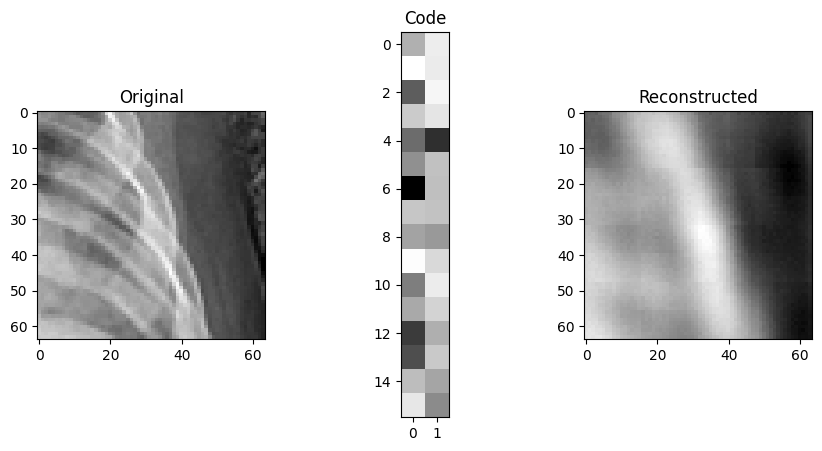

1/1 [==============================] - 0s 87ms/step


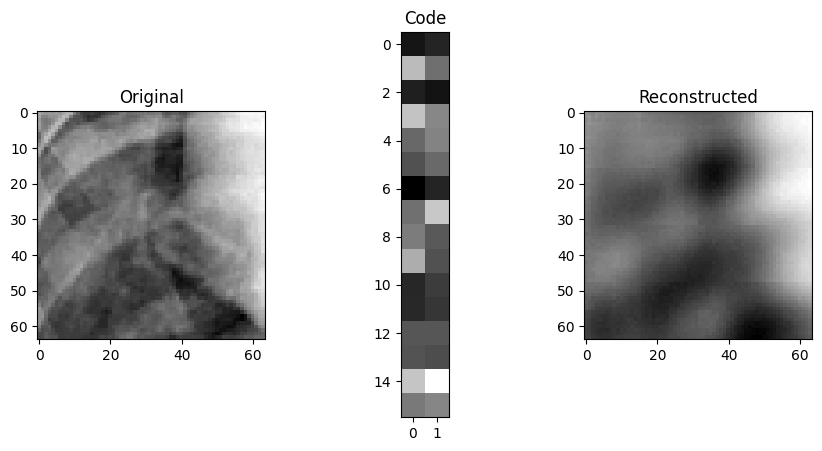

1/1 [==============================] - 0s 79ms/step


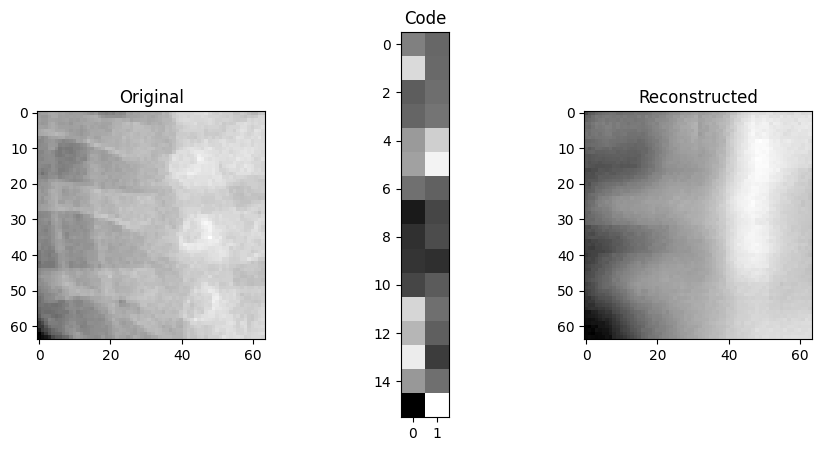

1/1 [==============================] - 0s 76ms/step


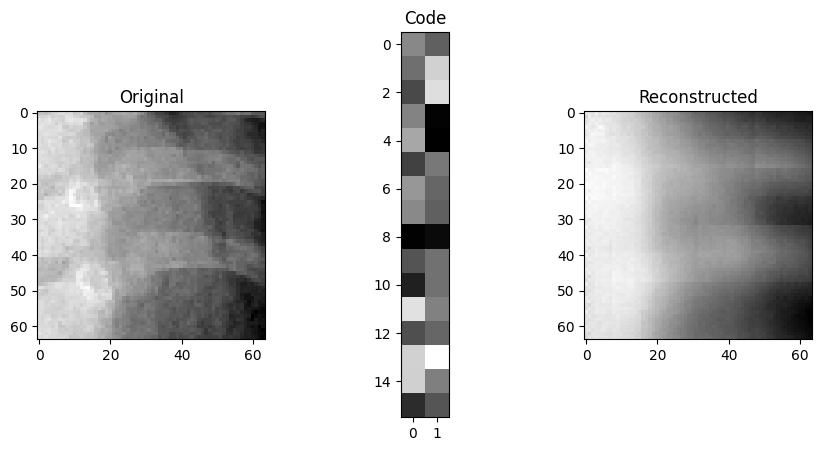

1/1 [==============================] - 0s 95ms/step


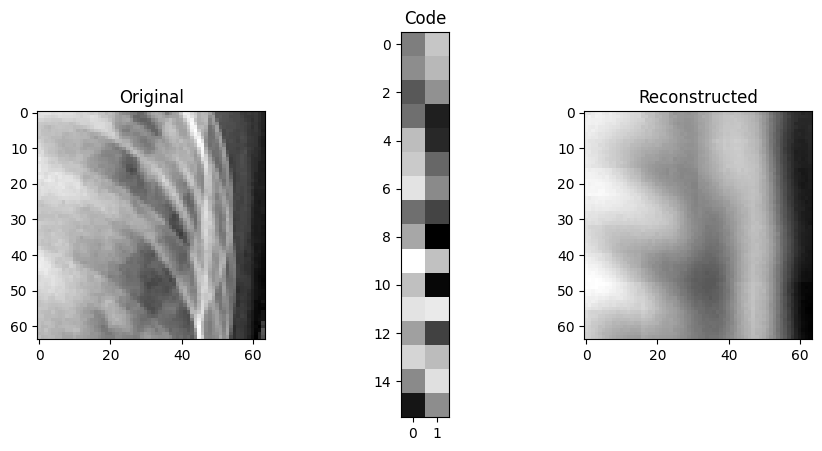

1/1 [==============================] - 0s 85ms/step


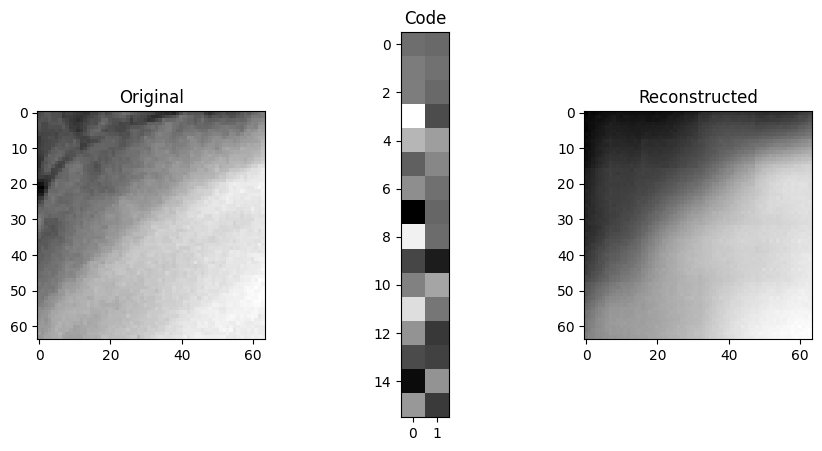

1/1 [==============================] - 0s 87ms/step


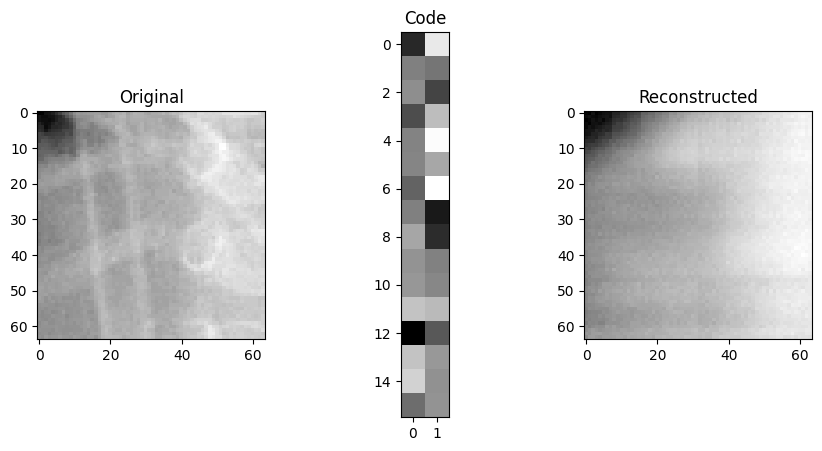

1/1 [==============================] - 0s 94ms/step


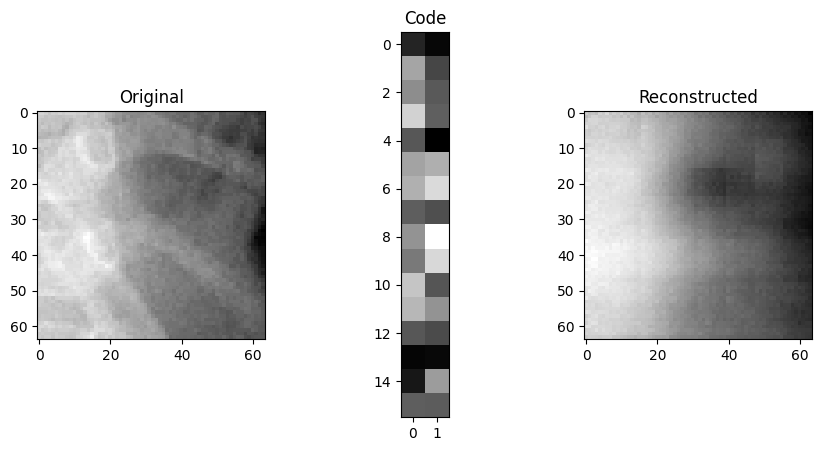

1/1 [==============================] - 0s 81ms/step


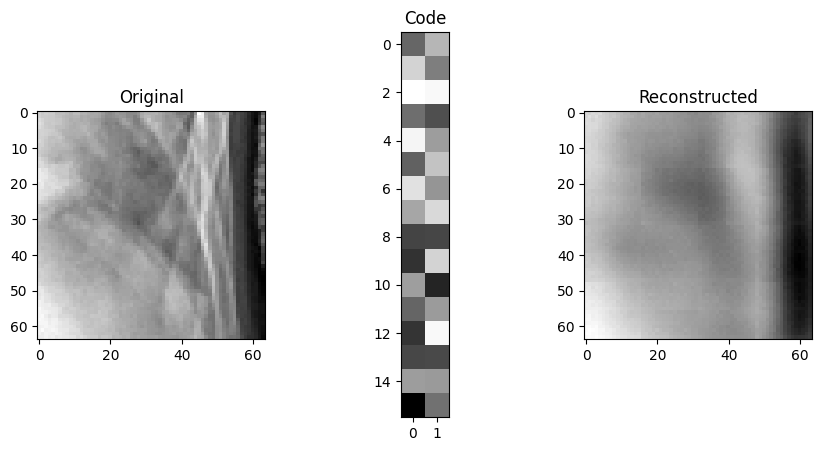

In [63]:
for i in range(NO_SUBPATCHES):
    subpatch = subpatches[i]
    plt.figure(figsize=(10, 5))
    utils.visualize(subpatch, encoders[i], decoders[i])
    plt.show()

### Load the classifier models

In [64]:
models = []
for i in range (NO_SUBPATCHES):
    models.append(load_model("../models_r/model"+ str(i) +".h5"))

### Predict image class

In [65]:
import numpy as np

predictions = []
for i in range(NO_SUBPATCHES):
    subpatch = subpatches[i]
    model = models[i]
    
    # Reshape subpatch to match model input shape
    subpatch_reshaped = np.expand_dims(subpatch, axis=0)
    subpatch_reshaped = np.expand_dims(subpatch_reshaped, axis=-1)
        
    # Make predictions with each model
    p = model.predict(subpatch_reshaped)
    predicted_class = np.argmax(p)
    certainty = p[0][predicted_class]
    certainty_formatted = "{:.2f}".format(certainty)
    print("Model for subpatch {} predicted class {} with certainty {}".format(i, predicted_class, certainty_formatted))
    predictions.append(p)
    
# Average the predictions
avg_predictions = np.mean(predictions, axis=0)
predicted_class = np.argmax(avg_predictions)

certainty = avg_predictions[0][predicted_class]
certainty_formatted = "{:.2f}".format(certainty)

# Choose the class with the highest probability for each sample
ensemble_predictions = np.argmax(avg_predictions, axis=1)
print("Ensemble predicted class {} with certainty {}".format(predicted_class, certainty_formatted))
print("Actual class label: {}".format(actual_label))

1/1 [==============================] - 0s 71ms/step
Model for subpatch 0 predicted class 2 with certainty 1.00
1/1 [==============================] - 0s 71ms/step
Model for subpatch 1 predicted class 2 with certainty 0.97
1/1 [==============================] - 0s 69ms/step
Model for subpatch 2 predicted class 2 with certainty 1.00
1/1 [==============================] - 0s 68ms/step
Model for subpatch 3 predicted class 1 with certainty 0.57
1/1 [==============================] - 0s 77ms/step
Model for subpatch 4 predicted class 2 with certainty 1.00
1/1 [==============================] - 0s 95ms/step
Model for subpatch 5 predicted class 1 with certainty 0.97
1/1 [==============================] - 0s 76ms/step
Model for subpatch 6 predicted class 2 with certainty 0.99
1/1 [==============================] - 0s 82ms/step
Model for subpatch 7 predicted class 2 with certainty 0.98
1/1 [==============================] - 0s 80ms/step
Model for subpatch 8 predicted class 2 with certainty 1.00
1